# Classifier Tester

The goal of this program is to select the best classifier for each given sampler.
Based on the criteria of reducing false negatives while keeping a degree of usefulness in detecting true negatives. The program allows the user to test the classifiers on a balanced dataset through crossvalidation, or on an unbalanced dataset that includes the false pulsars eliminated during the balancing process. 


In previous studies found online, the classifiers were both tested and trained in the unbalanced HTRU dataser. The high accuracy shown by a classifier both trained and tested in datasets that are highly unbalanced might be the result of paradoxical accuracy. To prevent this, the classifiers are to be trained on balanced datasets.

In the context of supporting astronomical clasification of new pulsar candidates, the datasets of pulsar candidates are likely to contain a much larger number of false-pulsars than of actual pulsars. So it is relevant to know how each classifier trained on balanced data performs when tested on a dataset with a very unbalanced distribution. This program allows you to select different samplers to balance your data and see how they perform when combined with certain classifiers when tested on both balanced and unbalanced test sets. 
The program is expected to operate as part of a HITL system, in which a human anotator would review the objects classified as pulsars by the classifiers, but would not review most of those classified as non pulsars. As a result of this setting, the program favours algorithms with very low false negative rates over those with high overall accuracy.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from statistics import stdev
from statistics import mean

from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NeighbourhoodCleaningRule

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import BorderlineSMOTE

from sklearn import preprocessing
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

from sklearn.preprocessing import MinMaxScaler

In [13]:
%run Aux_Methods.ipynb

In [3]:
best_results_per_main_run = []

In [4]:
df_0 = pd.read_csv("HTRU_2.csv")
keys = df_0.keys()
class_key = keys[len(keys) - 1]

df_0 = prepare_data(df_0, 0)
df_0.head()

The final dataset contains 17898 samples


,Mean_IP,Standard_Dev_IP,E_Kurtosis_IP,Skewness_IP,Mean_SNR,Standard_Dev_SNR,E_Kurtosis_SNR,Skewness_SNR,Class
0,0.721342,0.417687,0.165043,0.015627,0.013382,0.113681,0.294986,0.063890,0.0
1,0.517628,0.460908,0.235415,0.018268,0.006560,0.072524,0.364015,0.108443,0.0
2,0.520346,0.196868,0.221138,0.040677,0.013030,0.139188,0.288624,0.054610,0.0
3,0.700933,0.437884,0.181750,0.016534,0.015368,0.131583,0.266348,0.046581,0.0
4,0.443854,0.214847,0.249044,0.041712,0.004327,0.039684,0.462029,0.213369,0.0


### Add Classifiers to Evaluate

In [5]:
# Feel free to add classifiers and parameters! :)

classifiers = [
    KNeighborsClassifier,
    svm.SVC,
    LogisticRegression,
    DecisionTreeClassifier,
]

classifiers_names = [
    "KNeighborsClassifier",
    "svm.SVC",
    "LogisticRegression",
    "DecisionTreeClassifier",
]

parameters = [
    ["n_neighbors", range(3, 10)],
    ["kernel", ["linear", "rbf"]],
    ["random_state", range(6, 16, 3)],
    ["criterion", ["gini", "entropy", "log_loss"]],
]

## Performance of Under-Sampler and Classifier Combinations

### Add Undersamplers to Evaluate

In [6]:
# Feel free to add classifiers and parameters! :)

samplers_und = [
    AllKNN(),
    TomekLinks(),
    RandomUnderSampler(random_state=0),
    NeighbourhoodCleaningRule(n_neighbors=4),
]
samplers_names_und = [
    "AllKNN()",
    "TomekLinks()",
    "RandomUnderSampler(random_state=0)",
    "NeighbourhoodCleaningRule(n_neighbors=4)",
]

In [14]:
# Runs and cross vlaidates all combinations of undersamplers and classifiers.
# Evaluates their performance according to the criteria in the flags.
# Displays the confussion matrix of the best performing combination.
# Flag inbalance_testset allows to create an inbalanced testset.


def main_undersample(criteria_flag, flag_im_testset=False):

    total_dict = {}
    if flag_im_testset:
        df = df_0.copy()
    else:
        df = None

    for sampler, name in zip(samplers_und, samplers_names_und):

        dict_sampler = {}
        df_bal = get_balanced_set_undersampling(sampler, df_0.copy(), class_key)

        for classifier_cons, classifier_name, parameter in zip(
            classifiers, classifiers_names, parameters
            ):

            k, v = run_classifier(
                df_bal, classifier_cons, classifier_name, parameter, criteria_flag, df
                )
            dict_sampler[k] = v

        total_dict[min(dict_sampler)] = [dict_sampler[min(dict_sampler)], name]

    #    #Uncomment to see best results per sampler:
    #    print('Best total result for undersampling balancing:')
    #    my_cross_confussion_matrix(total_dict[min(total_dict)][0],total_dict[min(total_dict)][1])

    return total_dict[min(total_dict)][0], total_dict[min(total_dict)][1]


In [15]:
# Flag=0 will score classifiers depending on various criteria.
# Flag=1 will pick the result with the lowest false negative score


criteria_flag=0  

### Performance for Balanced Training and Test Sets

In [16]:
values, sampler_name = main_undersample(criteria_flag, False)
best_results_per_main_run.append([values, sampler_name])

### Best Result

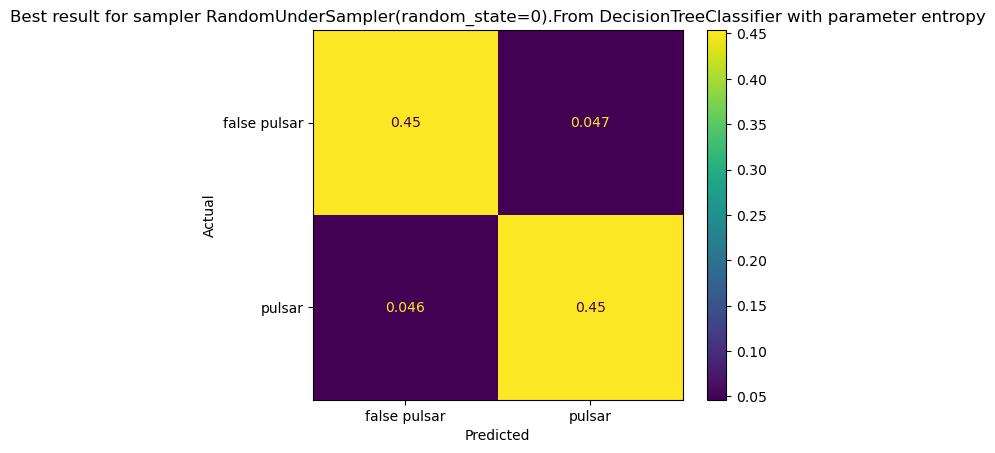

In [17]:
my_cross_confussion_matrix(values, sampler_name)

### Performance for Balanced Training Set and Imbalanced Test Set

In [18]:
values, sampler_name = main_undersample(criteria_flag,True)
best_results_per_main_run.append([values, sampler_name])

### Best Result

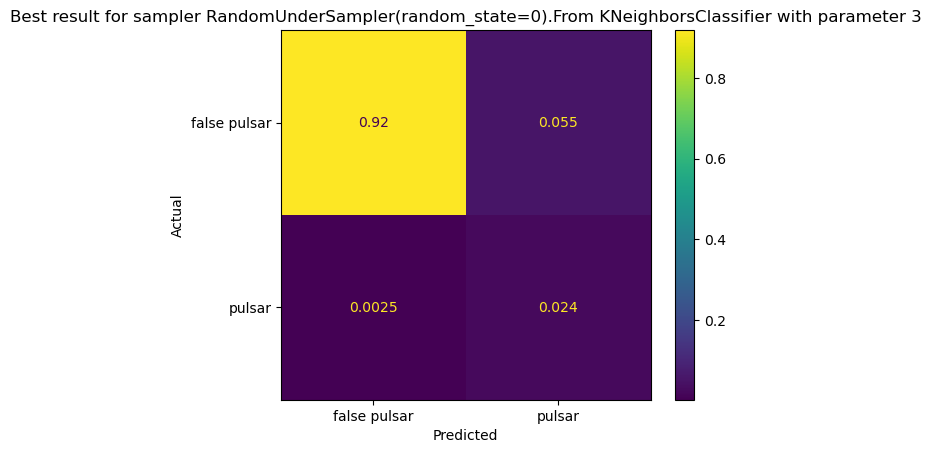

In [19]:
my_cross_confussion_matrix(values, sampler_name)

## Performance of Over-Sampler and Classifier Combinations

### Add Oversamplers to Evaluate

In [20]:
samplers_overs=[ADASYN(),SMOTE(),BorderlineSMOTE()]
samplers_names_overs=['ADASYN()','SMOTE()','BorderlineSMOTE()']

### Performance for Balanced Training Set and Imbalanced Test Set

In [25]:
# Runs and cross validates all combinations of oversamplers and classifiers.
# Evaluates their performance according to the criteria in the flags.
# Displays the confussion matrix of the best performing combination.
# Flag inbalance_testset allows to create an inbalanced testset.


def main_oversample(inbalance_testset=0):

    total_dict = {}

    for sampler, name in zip(samplers_overs, samplers_names_overs):
        dict_sampler = {}
        df_bal = get_balanced_set_oversampling(sampler, df_0.copy(), class_key)

        for classifier_cons, classifier_name, parameter in zip(
            classifiers, classifiers_names, parameters
        ):
            k, v = run_classifier(df_bal, classifier_cons, classifier_name, parameter, criteria_flag)
            dict_sampler[k] = v

        total_dict[min(dict_sampler)] = [dict_sampler[min(dict_sampler)], name]

        print(f"Best result for Sampler {name}:")
        my_cross_confussion_matrix(dict_sampler[min(dict_sampler)], name)

    #    #Uncomment to see best results per sampler:
    print(f'Best total result for undersampling balancing:')
    # my_cross_confussion_matrix(total_dict[min(total_dict)][0],total_dict[min(total_dict)][1])
    
    return total_dict[min(total_dict)][0], total_dict[min(total_dict)][1]


Best result for Sampler ADASYN():


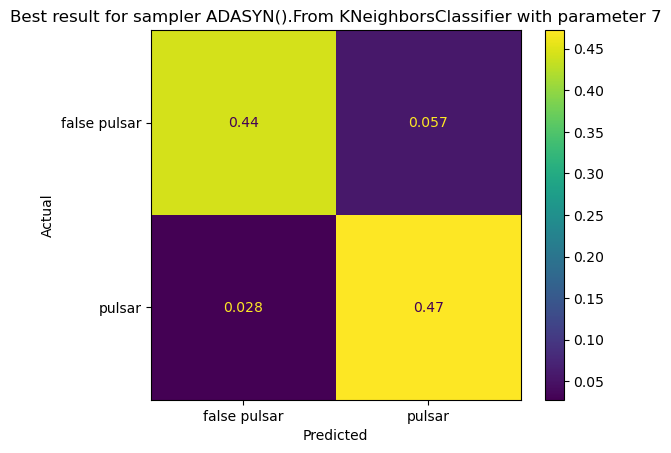

Best result for Sampler SMOTE():


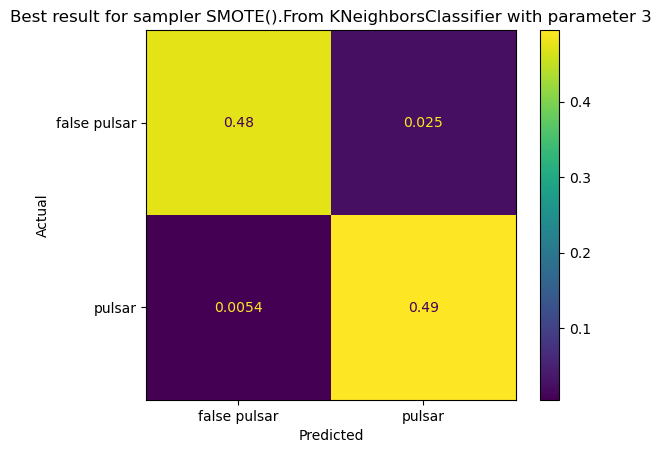

Best result for Sampler BorderlineSMOTE():


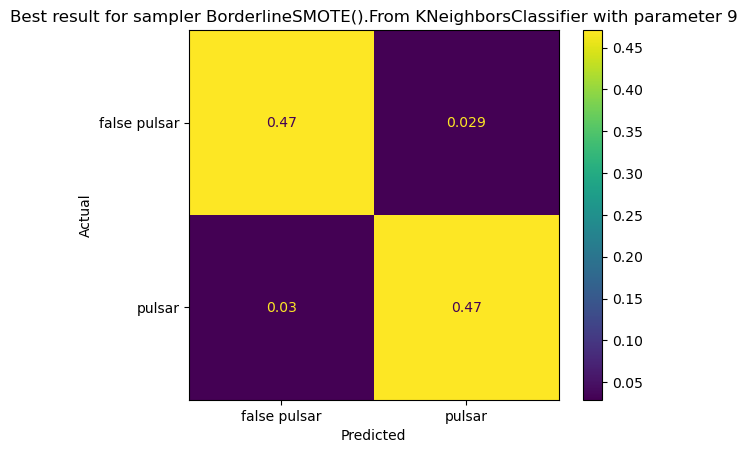

Best total result for undersampling balancing:


In [26]:
values, sampler_name=main_oversample(criteria_flag)
best_results_per_main_run.append([values, sampler_name])

## Sumary

In [27]:
#Displays the best results for each run in a single figure

def sumary():
    case = [
        "Oversampling.",
        "Undersampling. Balanced Test",
        "Undersampling. Imbalanced Test",
    ]

    f, axes = plt.subplots(1, len(best_results_per_main_run), figsize=(20, 10), sharey="row")
    plt.subplots_adjust(top=0.85, bottom=0.01, hspace=0.5, wspace=0.4)
    i = 0
    for n in best_results_per_main_run:

        cm = ConfusionMatrixDisplay(n[0][0], display_labels=["false pulsar", "pulsar"])
        cm.plot(ax=axes[i], xticks_rotation=45)
        t0 = case[i]
        t1 = f"{n[1]}."
        t2 = f" {n[0][1]} withp={n[0][2]} "

        cm.ax_.set(title=t0 + "\n" + t1 + "\n" + t2, xlabel="Predicted", ylabel="Actual")
        cm.im_.colorbar.remove()
        cm.ax_.set_xlabel("")
        i = i + 1

    f.text(0.4, 0.1, "Predicted label", ha="left")
    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    plt.show()


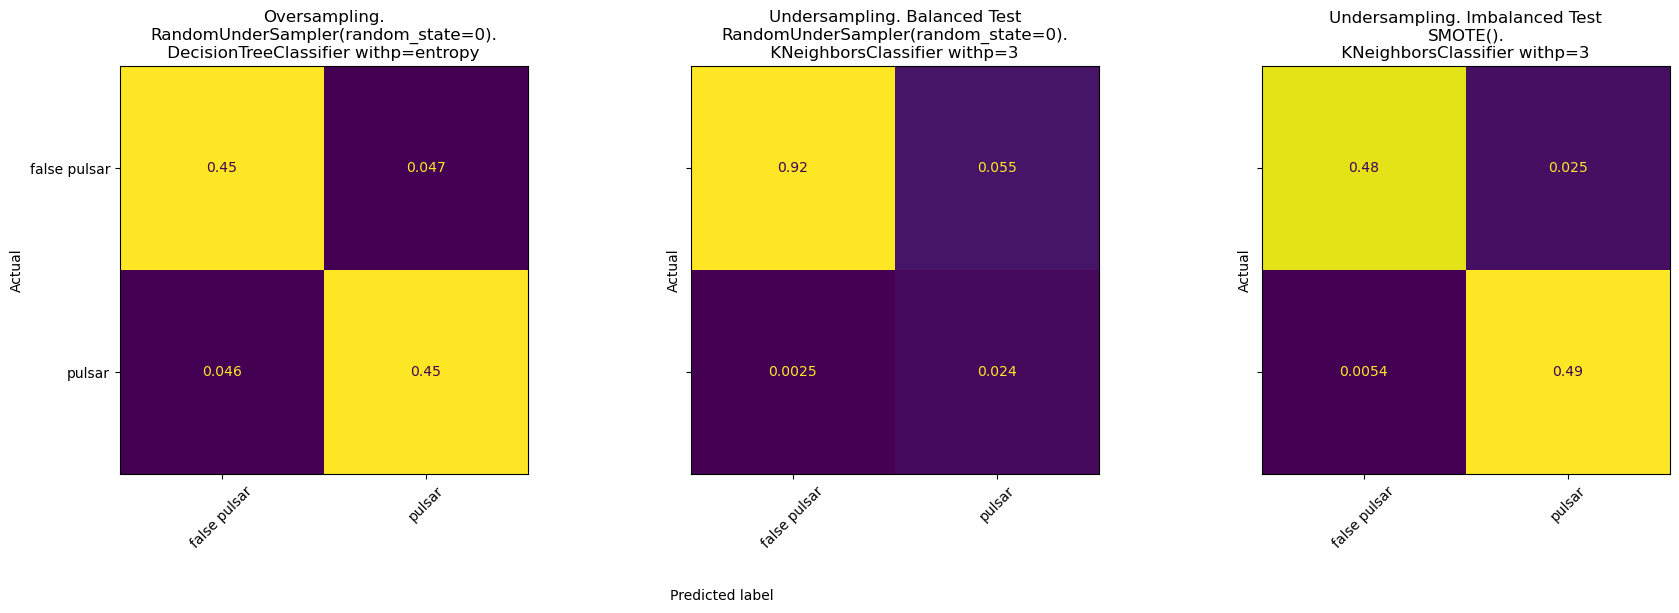

In [28]:
sumary()